### Time Series Forecasting
In the time series prediction, it is common to use the historical value of the target variable to predict its future value. 

We refer to a series of data points indexed (or graphed) in time order as a time series. A time series can be broken down into 3 components.
Trend: Upward & downward movement of the data with time over a large period of time (i.e. house appreciation)
Seasonality: Seasonal variance (i.e. an increase in demand for ice cream during summer)
Noise: Spikes & troughs at random intervals

### Autoregressive Integrated Moving Average, or ARIMA
is one of the most widely used forecasting methods for univariate time series data forecasting
Although the method can handle data with a trend, it does not support time series with a seasonal component.
An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMA.

### Seasonal Autoregressive Integrated Moving Average, or SARIMA
method for time series forecasting with univariate data containing trends and seasonality.

### Gated Recurrent Unit, or GRU 
Eeature Matrix can be fed into the Convolution Neural Network (CNN) for pattern recognition. Each feature Matrix would be fed as the channel of the CNN layer. The output of the Convolution will be flattened and then be fed to the layer of GRU, and finally to a linear layer to predict its future value.

In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
from datetime import timedelta
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline
import yfinance as yf # pip install yfinance
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Bidirectional
from keras.layers import GRU
from tensorflow import keras
from tkinter import *
import tkinter as tk

In [2]:
# select currency
def show_entry_fields():
    global currency 
    currency = tkvar.get()
    root.destroy()
    print("Currency: %s" % (tkvar.get()))
root = Tk()
tkvar = StringVar(root)
# Dictionary with options
choices = sorted({'BTC', 'ADA', 'ETH','MATIC','XRP','LTC','NEO','VET','SHIB','TRX','DOGE','BNB'})
tkvar.set('ADA')  # set the default option
popupMenu = OptionMenu(root, tkvar, *choices)
Label(root, text = "Please choose your desired currency").grid(row = 2, column = 0)
popupMenu.grid(row = 2, column = 1)
tk.Button(root, text = 'Show', command = show_entry_fields).grid(row = 3, column = 1, sticky = tk.W, pady = 4)
root.mainloop()

Currency: ADA


In [3]:
# Selecting Yahoo Finance Data from date 'ADS-USA'

start_date = '2016-01-01'
end_date = '2020-12-31'

train = yf.download('ADA-USD',start_date, end_date)
train.reset_index(inplace=True)
target_col = 'Close'
train.index = pd.to_datetime(train.Date, unit='s')
train = train.set_index('Date')
print(train)

today =  datetime.now().strftime("%Y-%m-%d")
#print(today)
todayy = datetime.strptime(today, '%Y-%m-%d').date()
# print(todayy)

test_start_date = '2021-01-01'
test_end_date = (todayy + timedelta(days = 1)).strftime('%Y-%m-%d')
#print(next_day)

test = yf.download('ADA-USD',test_start_date, test_end_date)
test.reset_index(inplace=True)
test.index = pd.to_datetime(test.Date, unit='s')
test = test.set_index('Date')
print(test)

[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close      Volume
Date                                                                     
2017-11-09  0.025160  0.035060  0.025006  0.032053   0.032053    18716200
2017-11-10  0.032219  0.033348  0.026451  0.027119   0.027119     6766780
2017-11-11  0.026891  0.029659  0.025684  0.027437   0.027437     5532220
2017-11-12  0.027480  0.027952  0.022591  0.023977   0.023977     7280250
2017-11-13  0.024364  0.026300  0.023495  0.025808   0.025808     4419440
...              ...       ...       ...       ...        ...         ...
2020-12-26  0.157556  0.161981  0.149824  0.157824   0.157824  1191970341
2020-12-27  0.157835  0.165190  0.150378  0.154422   0.154422  1578354821
2020-12-28  0.154440  0.178583  0.153445  0.176735   0.176735  1732151279
2020-12-29  0.176709  0.196170  0.174039  0.192164   0.192164  2967669490
2020-12-30  0.192022  0.193144  0.175681  0

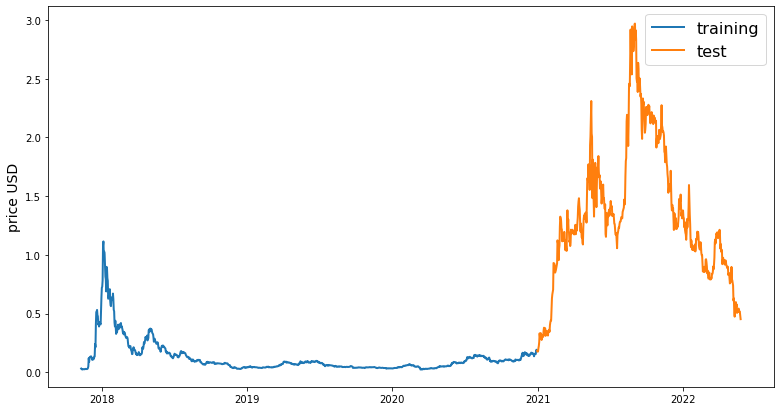

In [4]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price USD', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [5]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [6]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [7]:
def prepare_data(target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data=train
    test_data =test
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [8]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model


In [9]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [10]:
train, test, X_train, X_test, y_train, y_test = prepare_data(target_col, window_len=window_len, \
                                                             zero_base=zero_base, test_size=test_size)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
36/36 [==============================] - 3s 7ms/step - loss: 0.0593
Epoch 2/20
36/36 [==============================] - 0s 8ms/step - loss: 0.0238
Epoch 3/20
36/36 [==============================] - 0s 9ms/step - loss: 0.0196
Epoch 4/20
36/36 [==============================] - 0s 9ms/step - loss: 0.0161
Epoch 5/20
36/36 [==============================] - 0s 11ms/step - loss: 0.0157
Epoch 6/20
36/36 [==============================] - 0s 10ms/step - loss: 0.0149
Epoch 7/20
36/36 [==============================] - 0s 11ms/step - loss: 0.0111
Epoch 8/20
36/36 [==============================] - 0s 7ms/step - loss: 0.0137
Epoch 9/20
36/36 [==============================] - 0s 7ms/step - loss: 0.0136
Epoch 10/20
36/36 [==============================] - 0s 7ms/step - loss: 0.0138
Epoch 11/20
36/36 [==============================] - 0s 7ms/step - loss: 0.0118
Epoch 12/20
36/36 [==============================] - 0s 6ms/step - loss: 0.0129
Epoch 13/20
36/36 [===========================

In [11]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.055028811025503645

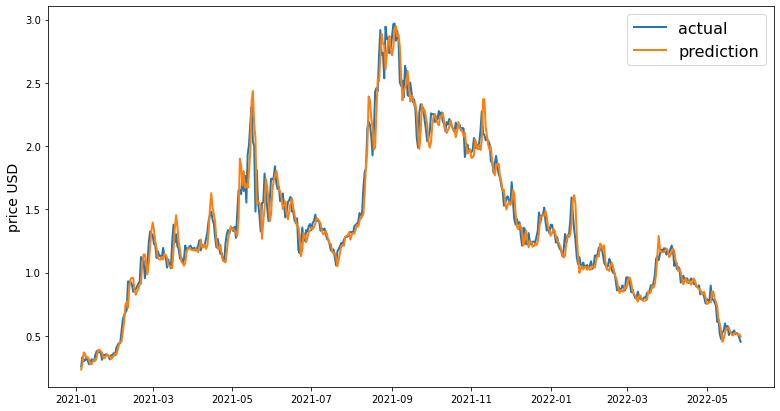

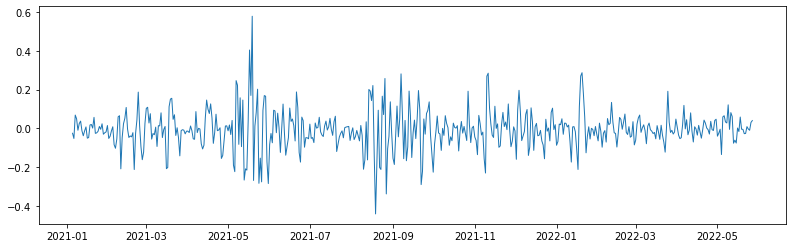

In [12]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index = targets.index, data = preds)
line_plot(targets, preds, 'actual', 'prediction', lw = 2)
df = pd.DataFrame(preds, columns = ['ClosePredict'])
df['CloseActual'] = test['Close']
df['diff'] = df['ClosePredict'] - df['CloseActual']

plt.figure(figsize = (13.4, 4))
plt.plot(df["diff"],label = "difference",lw = 1)

In [13]:
df

ClosePredict  CloseActual      diff
Date                                           
2021-01-05      0.233475     0.258314 -0.024839
2021-01-06      0.280372     0.331898 -0.051526
2021-01-07      0.368767     0.299980  0.068787
2021-01-08      0.355496     0.305597  0.049899
2021-01-09      0.323834     0.332973 -0.009139
...                  ...          ...       ...
2022-05-23      0.521953     0.512605  0.009348
2022-05-24      0.518403     0.521224 -0.002821
2022-05-25      0.504460     0.513877 -0.009417
2022-05-26      0.511632     0.480883  0.030749
2022-05-27      0.493002     0.452577  0.040424

[508 rows x 3 columns]

In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train.Close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#train.reset_index(inplace=True)

ADF Statistic: -3.346451
p-value: 0.012926


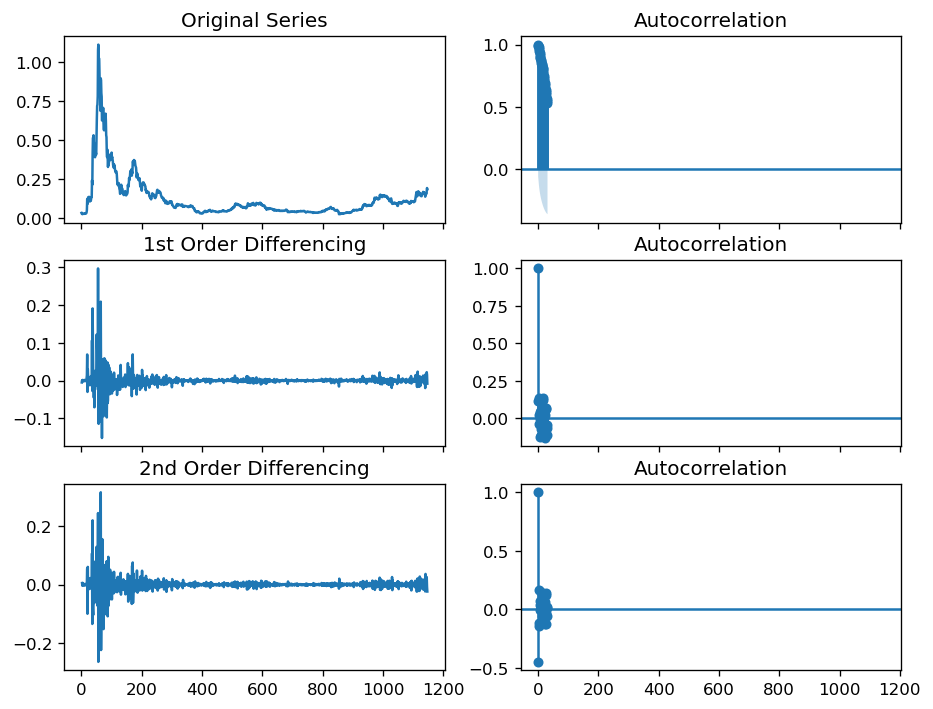

In [15]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df = train.copy()
df.reset_index(inplace=True)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.Close); axes[0, 0].set_title('Original Series')
plot_acf(df.Close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.Close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [16]:
df

Date      Open      High       Low     Close  Adj Close      Volume
0    2017-11-09  0.025160  0.035060  0.025006  0.032053   0.032053    18716200
1    2017-11-10  0.032219  0.033348  0.026451  0.027119   0.027119     6766780
2    2017-11-11  0.026891  0.029659  0.025684  0.027437   0.027437     5532220
3    2017-11-12  0.027480  0.027952  0.022591  0.023977   0.023977     7280250
4    2017-11-13  0.024364  0.026300  0.023495  0.025808   0.025808     4419440
...         ...       ...       ...       ...       ...        ...         ...
1143 2020-12-26  0.157556  0.161981  0.149824  0.157824   0.157824  1191970341
1144 2020-12-27  0.157835  0.165190  0.150378  0.154422   0.154422  1578354821
1145 2020-12-28  0.154440  0.178583  0.153445  0.176735   0.176735  1732151279
1146 2020-12-29  0.176709  0.196170  0.174039  0.192164   0.192164  2967669490
1147 2020-12-30  0.192022  0.193144  0.175681  0.184040   0.184040  1849432295

[1148 rows x 7 columns]

In [17]:
from pmdarima.arima.utils import ndiffs
df = train.copy()
y = df.Close

## Adf Test
ndiffs(y, test = 'adf')  # 2

# KPSS test
ndiffs(y, test = 'kpss')  # 0

# PP test:
ndiffs(y, test = 'pp')  # 2

df.reset_index(inplace=True)
df

Date      Open      High       Low     Close  Adj Close      Volume
0    2017-11-09  0.025160  0.035060  0.025006  0.032053   0.032053    18716200
1    2017-11-10  0.032219  0.033348  0.026451  0.027119   0.027119     6766780
2    2017-11-11  0.026891  0.029659  0.025684  0.027437   0.027437     5532220
3    2017-11-12  0.027480  0.027952  0.022591  0.023977   0.023977     7280250
4    2017-11-13  0.024364  0.026300  0.023495  0.025808   0.025808     4419440
...         ...       ...       ...       ...       ...        ...         ...
1143 2020-12-26  0.157556  0.161981  0.149824  0.157824   0.157824  1191970341
1144 2020-12-27  0.157835  0.165190  0.150378  0.154422   0.154422  1578354821
1145 2020-12-28  0.154440  0.178583  0.153445  0.176735   0.176735  1732151279
1146 2020-12-29  0.176709  0.196170  0.174039  0.192164   0.192164  2967669490
1147 2020-12-30  0.192022  0.193144  0.175681  0.184040   0.184040  1849432295

[1148 rows x 7 columns]

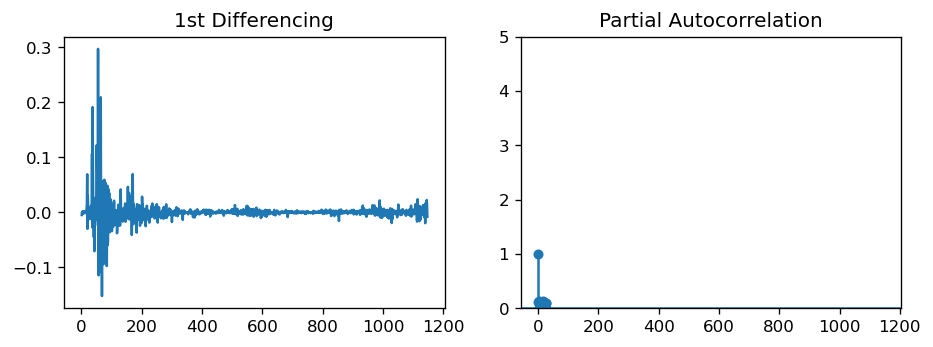

In [18]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex = True)
axes[0].plot(df.Close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim = (0,5))
plot_pacf(df.Close.diff().dropna(), ax=axes[1])

plt.show()

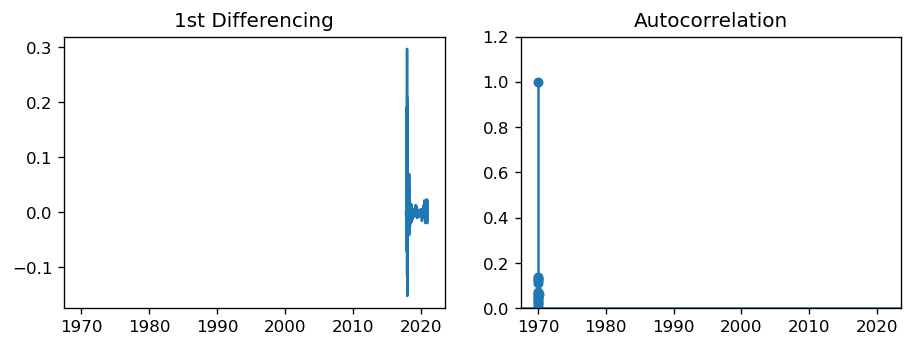

In [19]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data
df = train.copy()

fig, axes = plt.subplots(1, 2, sharex = True)
axes[0].plot(df.Close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim = (0,1.2))
plot_acf(df.Close.diff().dropna(), ax = axes[1])

plt.show()

In [20]:
# ARIMA Results
import statsmodels.api as sm

# 1,1,2 ARIMA Model
model = sm.tsa.arima.ARIMA(df.Close, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1148
Model:                 ARIMA(1, 1, 2)   Log Likelihood                2906.389
Date:                Sat, 28 May 2022   AIC                          -5804.778
Time:                        00:50:17   BIC                          -5784.599
Sample:                    11-09-2017   HQIC                         -5797.160
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7000      0.053    -13.165      0.000      -0.804      -0.596
ma.L1          0.8273      0.052     15.812      0.000       0.725       0.930
ma.L2          0.0214      0.016      1.323      0.1

In [21]:
model = sm.tsa.arima.ARIMA(df.Close, order=(1,1,1))
model_fit = model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


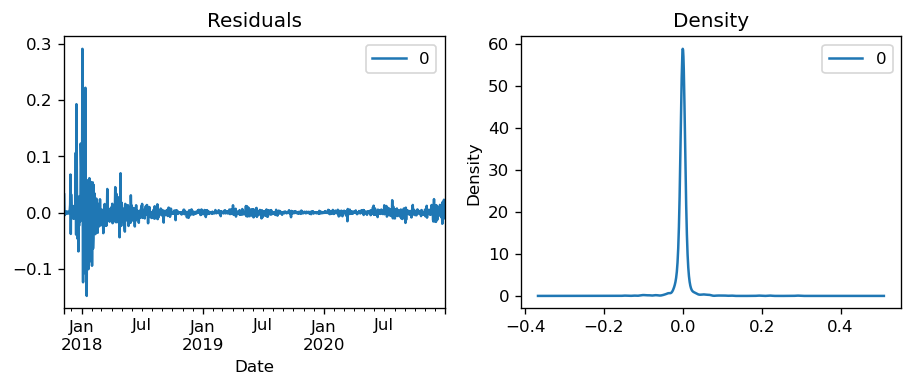

In [22]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

<ipython-input-23-47d273186fa5>:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  pred.Date = test.index


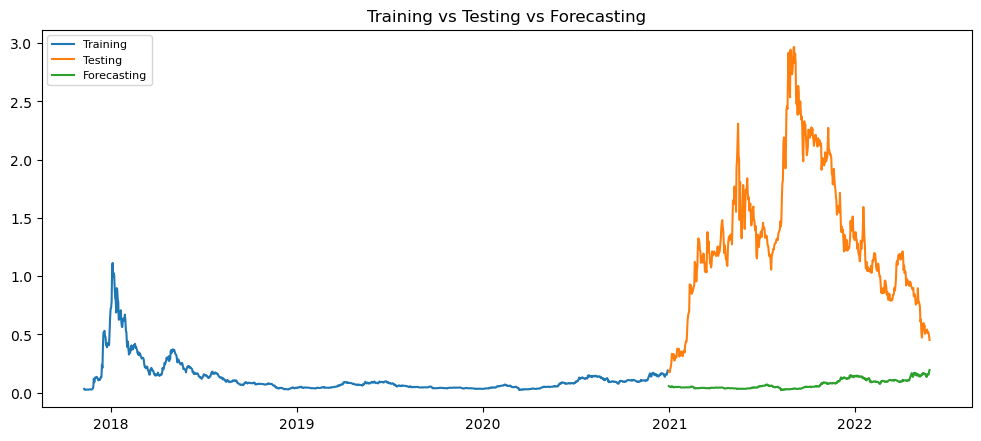

In [23]:
# Actual vs Fitted
plt.figure(figsize = (12,5), dpi = 100)
pred = model_fit.predict(len(train)-len(test))
pred = pd.DataFrame(pred)
pred.Date = test.index
plt.plot(train.index, train.Close,label = 'Training')
plt.plot(test.index,test.Close,label = 'Testing')
plt.plot(pred.Date,model_fit.predict(len(train)-len(test)),label = 'Forecasting')
plt.title('Training vs Testing vs Forecasting')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
<ipython-input-24-9cb76957e16c>:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  pred.Date = test.index


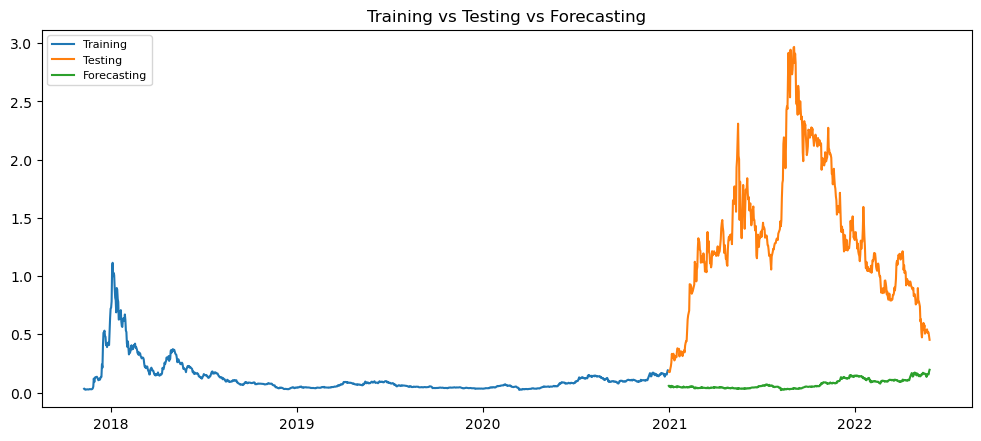

In [24]:
# SARIMAX
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(df.Close,order=(1, 1, 1),seasonal_order=(1,1,1,12))
model_fit = model.fit()

plt.figure(figsize = (12,5), dpi = 100)
pred = model_fit.predict(len(train)-len(test))
pred = pd.DataFrame(pred)
pred.Date = test.index
plt.plot(train.index, train.Close,label = 'Training')
plt.plot(test.index,test.Close,label = 'Testing')
plt.plot(pred.Date,model_fit.predict(len(train)-len(test)),label = 'Forecasting')
plt.title('Training vs Testing vs Forecasting')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

In [25]:
data = yf.download(currency+'-USD',start_date, today)
data

[*********************100%***********************]  1 of 1 completed


Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2017-11-09  0.025160  0.035060  0.025006  0.032053   0.032053   18716200
2017-11-10  0.032219  0.033348  0.026451  0.027119   0.027119    6766780
2017-11-11  0.026891  0.029659  0.025684  0.027437   0.027437    5532220
2017-11-12  0.027480  0.027952  0.022591  0.023977   0.023977    7280250
2017-11-13  0.024364  0.026300  0.023495  0.025808   0.025808    4419440
...              ...       ...       ...       ...        ...        ...
2022-05-23  0.542484  0.557805  0.509433  0.512605   0.512605  753004177
2022-05-24  0.512687  0.524259  0.495957  0.521224   0.521224  678125877
2022-05-25  0.521242  0.531462  0.508289  0.513877   0.513877  589015500
2022-05-26  0.513953  0.520108  0.466368  0.480883   0.480883  909554798
2022-05-27  0.481186  0.482871  0.447380  0.452577   0.452577  929845440

[1661 rows x 6 columns]

<ipython-input-26-080fea966aef>:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  pred.Date=test.index


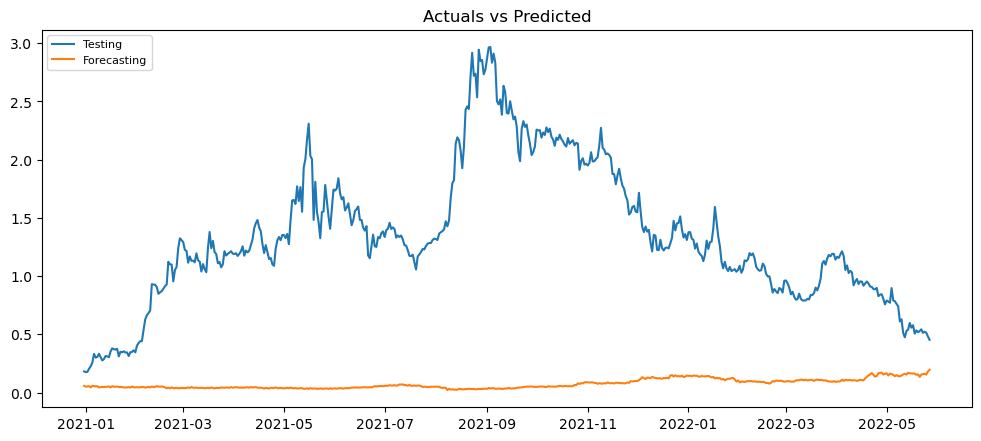

In [26]:
# Actual vs Fitted
from statsmodels.tsa.arima_model import ARIMA
plt.figure(figsize=(12,5), dpi=100)
pred=model_fit.predict(len(train)-len(test))
pred = pd.DataFrame(pred)
pred.Date=test.index
plt.plot(test.index,test.Close,label='Testing')
plt.plot(pred.Date,model_fit.predict(len(train)-len(test)),label='Forecasting')
plt.title('Actuals vs Predicted')
plt.legend(loc='upper left', fontsize=8)
plt.show()

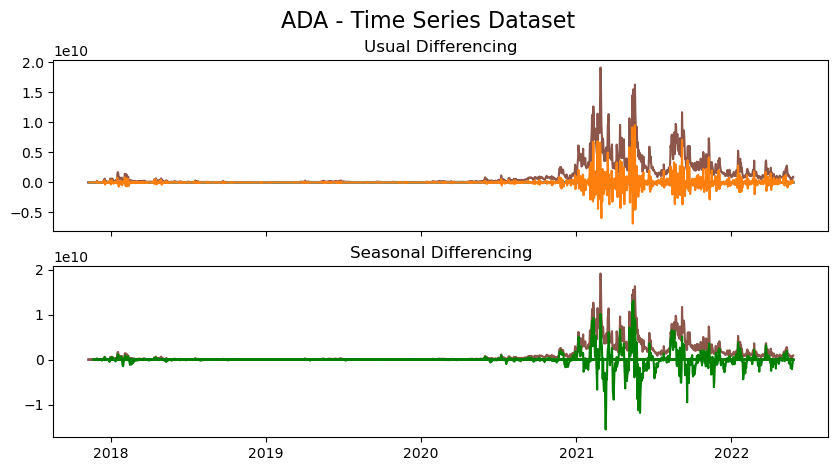

In [27]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
#axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
#plt.legend(loc='upper left', fontsize=10)
plt.suptitle(currency+' - Time Series Dataset', fontsize=16)
plt.show()

In [36]:
import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data['Close'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=11.05 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-1175.482, Time=0.48 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-4470.527, Time=3.99 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-2452.894, Time=4.27 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-1176.741, Time=0.30 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-3939.410, Time=0.68 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-4581.658, Time=25.72 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=34.29 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=9.92 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-1192.020, Time=6.64 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-4583.275, Time=37.77 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-4470.636, Time=8.71 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=47.91 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=18.00 sec
 ARIMA(3,0,0)(2,1,0)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1661
Model:             SARIMAX(2, 0, 2)x(2, 1, [], 12)   Log Likelihood                2307.509
Date:                             Sat, 28 May 2022   AIC                          -4601.018
Time:                                     01:15:38   BIC                          -4563.163
Sample:                                          0   HQIC                         -4586.982
                                            - 1661                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2626      0.051      5.194      0.000       0.163       0.362
ar.L2          0.6711      0.048     14.100      0.000       0.578       0.764
ma.L1          0.6699      0.052     12.888      0.000       0.568       0.772
ma.L2          0.0638      0.012      5.233      0.000       0.040       0.088
ar.S.L12      -0.6775      0.012    -57.901      0.000      -0.700      -0.655
ar.S.L24      -0.2560      0.013    -20.112      0.000      -0.281      -0.231
sigma2         0.0036   4.62e-05     77.156      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             14073.26
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               8.77   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

[0.50433831 0.4695352  0.45561641 0.46729613 0.4459111  0.40674732
 0.42997219 0.36980621 0.35252809 0.38998406 0.38949311 0.40965325
 0.44868348 0.42629217 0.39599482 0.41234721 0.39943569 0.36396765
 0.38803349 0.33171622 0.32505019 0.35321011 0.3466975  0.36083064]


<ipython-input-37-7f36e6963dbd>:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  pred.Date=test.index


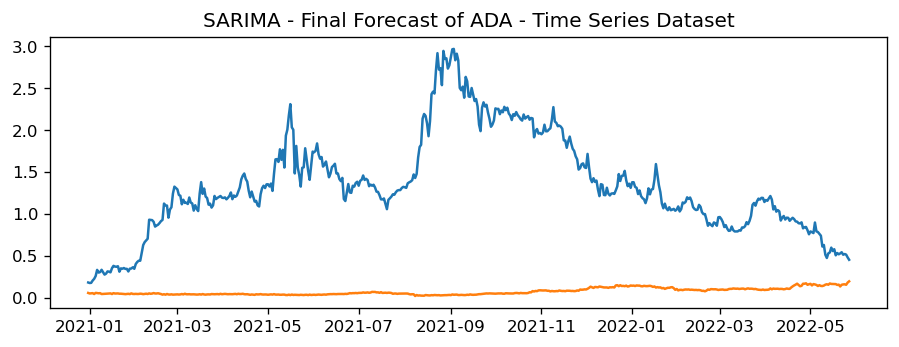

In [37]:
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')
print(fitted)
# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
pred = pd.DataFrame(fitted)
pred.Date=test.index
plt.plot(test.index,test.Close,label='Testing')
plt.plot(pred.Date,model_fit.predict(len(train)-len(test)),label='Forecasting')
plt.title("SARIMA - Final Forecast of "+currency+" - Time Series Dataset")
plt.show()
# Plot
#plt.plot(data)
#plt.plot(fitted_series, color='darkgreen')


In [38]:
# Create variable 'TOMORROW_CLOSE' which shifts 'Close' up by 1
train['TOMORROW_CLOSE'] = train['Close']
test['TOMORROW_CLOSE'] = test['Close']

# drop last row because we shifted value (remember this when you add your forecasting data)
train.drop(train.tail(1).index,inplace=True) 

In [39]:
train_dataset, test_dataset = train,test

Dimension of train data:  (1147, 7)
Dimension of test data:  (513, 7)


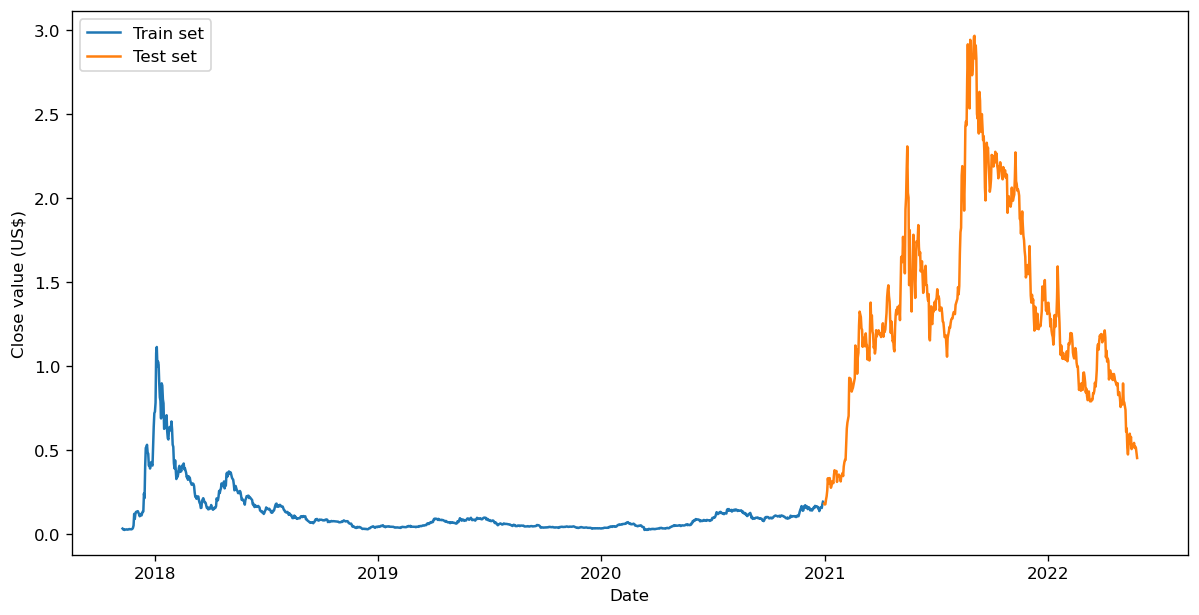

In [40]:
# Plot train and test data
plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(train_dataset.TOMORROW_CLOSE)
plt.plot(test_dataset.TOMORROW_CLOSE)
plt.xlabel('Date')
plt.ylabel('Close value (US$)')
plt.legend(['Train set', 'Test set'], loc='upper left')
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [41]:
# Split train data to X and y
X_train = train_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_train = train_dataset.loc[:,['TOMORROW_CLOSE']]

# Split test data to X and y
X_test = test_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_test = test_dataset.loc[:,['TOMORROW_CLOSE']]

In [42]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [43]:
def threeD_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 10

X_test, y_test = threeD_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = threeD_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1137, 10, 6)
y_train.shape:  (1137, 1)
X_test.shape:  (503, 10, 6)
y_test.shape:  (503, 1)


In [44]:
# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    # First layer of GRU
    model.add(m (units = units, return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Second layer of GRU
    model.add(m (units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# GRU
model_gru = create_model(64, GRU)

In [60]:
# Fit BiLSTM, LSTM and GRU

def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

    # Set shuffle equal to False due to importance of oder for this dataset
    history = model.fit(X_train, y_train, epochs = 20, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

history_gru = fit_model(model_gru)

Epoch 1/64
29/29 [==============================] - 16s 467ms/step - loss: 0.0078 - val_loss: 0.0035
Epoch 2/64
29/29 [==============================] - 13s 480ms/step - loss: 0.0079 - val_loss: 0.0041
Epoch 3/64
29/29 [==============================] - 13s 463ms/step - loss: 0.0081 - val_loss: 0.0046
Epoch 4/64
29/29 [==============================] - 11s 393ms/step - loss: 0.0079 - val_loss: 0.0050
Epoch 5/64
29/29 [==============================] - 12s 439ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 6/64
29/29 [==============================] - 11s 387ms/step - loss: 0.0079 - val_loss: 0.0065
Epoch 7/64
29/29 [==============================] - 20s 700ms/step - loss: 0.0073 - val_loss: 0.0048
Epoch 8/64
29/29 [==============================] - 14s 496ms/step - loss: 0.0083 - val_loss: 0.0038
Epoch 9/64
29/29 [==============================] - 14s 514ms/step - loss: 0.0061 - val_loss: 0.0025
Epoch 10/64
29/29 [==============================] - 14s 498ms/step - loss: 0.0060 - val_lo

In [61]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_gru = prediction(model_gru)

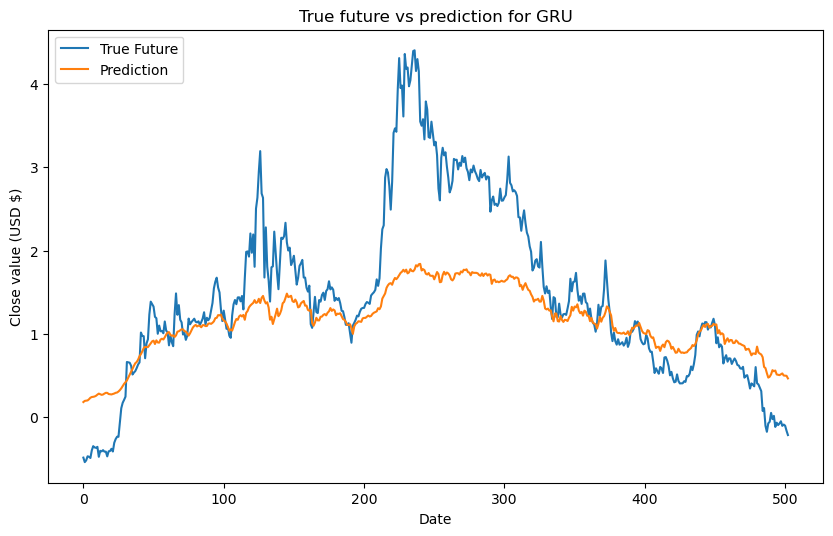

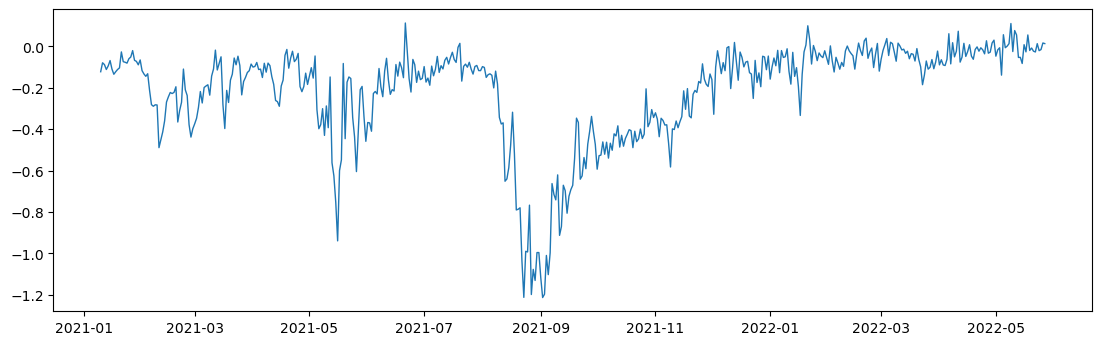

In [62]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    plt.rcParams['figure.dpi'] = 100
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Close value (USD $)')
   
    
plot_future(prediction_gru, 'GRU', y_test)

mlen = min(map(len, [test, prediction_gru]))
test=test.tail(mlen)

GRU = pd.DataFrame(prediction_gru, columns = ['ClosePredict'])
GRU.index=test.index
GRU['CloseActual']=test['Close']
GRU['diff'] = GRU['ClosePredict'] - GRU['CloseActual']
GRU

plt.figure(figsize=(13.4, 4))
plt.plot(GRU["diff"],label = "difference",lw=1)

In [63]:
def gru_model_tuning():
    model = Sequential()
    model.add(GRU(32, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.1))
    model.add(GRU(64))
    model.add(Dropout(0.1))
    model.add(Dense(units = 1))
    model.compile(loss='mse', optimizer='adam')
    return model

# GRU
model_gru1 = gru_model_tuning()

TypeError: 'DataFrame' object is not callable

In [64]:
def fit_model_gru(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

    # Set shuffle equal to False due to importance of oder for this dataset
    history = model.fit(X_train, y_train, epochs = 20, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

history_gru = fit_model_gru(model_gru1)

Epoch 1/20
29/29 [==============================] - 22s 566ms/step - loss: 0.0115 - val_loss: 0.0028
Epoch 2/20
29/29 [==============================] - 15s 542ms/step - loss: 0.0094 - val_loss: 0.0027
Epoch 3/20
29/29 [==============================] - 24s 847ms/step - loss: 0.0096 - val_loss: 0.0029
Epoch 4/20
29/29 [==============================] - 21s 748ms/step - loss: 0.0085 - val_loss: 0.0028
Epoch 5/20
29/29 [==============================] - 14s 486ms/step - loss: 0.0125 - val_loss: 0.0072
Epoch 6/20
29/29 [==============================] - 17s 596ms/step - loss: 0.0100 - val_loss: 0.0026
Epoch 7/20
29/29 [==============================] - 41s 1s/step - loss: 0.0080 - val_loss: 0.0015
Epoch 8/20
29/29 [==============================] - 24s 839ms/step - loss: 0.0080 - val_loss: 0.0012
Epoch 9/20
29/29 [==============================] - 21s 757ms/step - loss: 0.0097 - val_loss: 0.0033
Epoch 10/20
29/29 [==============================] - 18s 644ms/step - loss: 0.0099 - val_loss:

In [67]:
def prediction_gru(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_gru1 = prediction_gru(model_gru1)

TypeError: object of type 'function' has no len()

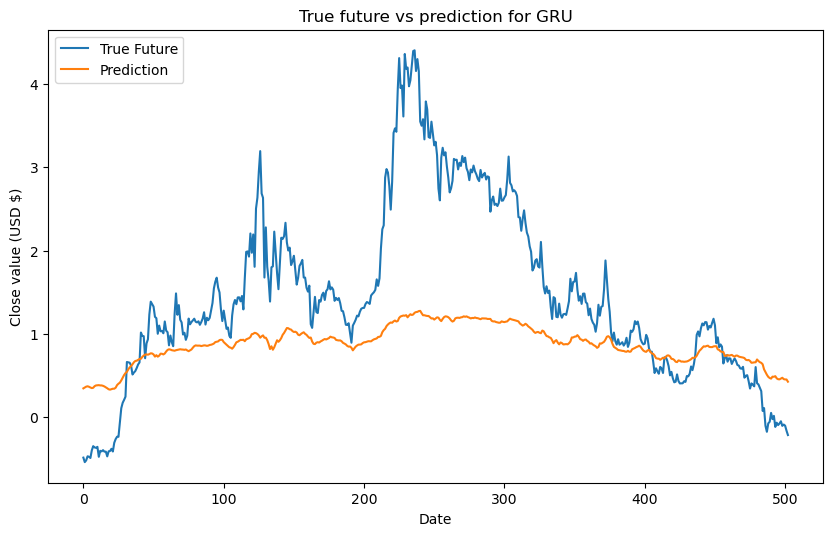

In [68]:
def plot_future_gru(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    plt.rcParams['figure.dpi'] = 100
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Close value (USD $)')
   
    
plot_future(prediction_gru1, 'GRU', y_test)

mlen = min(map(len, [test, prediction_gru]))
test=test.tail(mlen)

GRU = pd.DataFrame(prediction_gru, columns = ['ClosePredict'])
GRU.index=test.index
GRU['CloseActual']=test['Close']
GRU['diff'] = GRU['ClosePredict'] - GRU['CloseActual']
GRU

plt.figure(figsize=(13.4, 4))
plt.plot(GRU["diff"],label = "difference",lw=1)